## HASPEEDE


HASPEEDE is a task about identification of hateful content online.

In [99]:
### Imports ###
import numpy as np, pandas as pd, random, re, html, json, regex, string

# Utilities
from tqdm import tqdm
from pathlib import Path
from collections import Counter, OrderedDict

# Deep learning
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab, vocab
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# NLP libraries
import spacy
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')

# Graphing
import matplotlib, matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as font_manager
import seaborn as sns
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [101]:
!git clone -s https://github.com/Alessandro-vecchi/HASPEEDE.git haspeede

fatal: destination path 'haspeede' already exists and is not an empty directory.


### Loading Data

We are dealing with a binary classification problem where the goal is to identify whether a given text contains hate speech or is neutral. The dataset is structured as JSON lines, each containing a text string, possible classification choices, and a label indicating the correct class.

In [102]:
train_path = Path("haspeede/data/train-taskA.jsonl")
test_news_path = Path("haspeede/data/test-news-taskA.jsonl")
test_tweets_path = Path("haspeede/data/test-tweets-taskA.jsonl")

In [103]:
!head haspeede/data/train-taskA.jsonl -n 10 # -n NUM print the first NUM lines

{"text": "\u00c8 terrorismo anche questo, per mettere in uno stato di soggezione le persone e renderle innocue, mentre qualcuno... URL ", "choices": ["neutrale", "odio"], "label": 0}
{"text": "@user @user infatti finch\u00e9 ci hanno guadagnato con i campi #rom tutto era ok con #Alemanno #Ipocriti ", "choices": ["neutrale", "odio"], "label": 0}
{"text": "Corriere: Tangenti, Mafia Capitale dimenticataMazzette su buche e campi rom URL #roma ", "choices": ["neutrale", "odio"], "label": 0}
{"text": "@user ad uno ad uno, perch\u00e9 quando i migranti israeliti arrivarono in terra di Canaan fecero fuori tutti i Canaaniti. ", "choices": ["neutrale", "odio"], "label": 0}
{"text": "Il divertimento del giorno? Trovare i patrioti italiani che inneggiano contro i rom facendo la spesa alla #Lidl (multinazionale tedesca). ", "choices": ["neutrale", "odio"], "label": 0}
{"text": "Modena: Comune paga la benzina ai nomadi che portano figli a scuola: MODENA \u2013 La giunta PD\u2026 URL ", "choices": ["

In [104]:
!head haspeede/data/test-news-taskA.jsonl -n 5 

{"text": "\"Andate pure l\u00e0, tanto quei fessi degli italiani...\". Capito perch\u00e9 ci invadono? Il clandestino confessa", "choices": ["neutrale", "odio"], "label": 1}
{"text": "\"Che fine spero che faccia il killer nigeriano di Pamela\". La furia cieca della Meloni: le sue parole pi\u00f9 dure", "choices": ["neutrale", "odio"], "label": 1}
{"text": "\"Cos\u00ec i profughi ci svuotano i negozi a Pordenone\"", "choices": ["neutrale", "odio"], "label": 1}
{"text": "\"Cos\u00ec umiliano gli italiani e coccolano i clandestini\". La follia del governo: \"Per loro gratis...\", e ci invadono", "choices": ["neutrale", "odio"], "label": 1}
{"text": "\"Danno soldi ai clandestini, ma ai disabili invece...\". Bracconeri, il figlio autistico e il durissimo sfogo a \"Libero\"", "choices": ["neutrale", "odio"], "label": 1}


In [105]:
!head haspeede/data/test-tweets-taskA.jsonl -n 5

{"text": "@user A me pare una scelta politica suicida puntare tutto su una battaglia sicuramente perdente in favore dell'immigrazione incontrollata...Meglio cos\u00ec, spariranno pi\u00f9 velocemente!", "choices": ["neutrale", "odio"], "label": 1}
{"text": "@user e' un perfetto musulmano!!! chi dice il contrario mente, applica alla lettera la sura \"la donna\" del Corano. Il pericolo non e' lui in quanto tale, che lo dice, ma gli infami bugiardi! dell' islam moderato che NON ESISTE,", "choices": ["neutrale", "odio"], "label": 1}
{"text": "Mai Tg e i giornaloni hanno parlato di questa ennesima porcata fatta da immigrati ?? \u2935\ufe0f\u2935\ufe0f\u2935\ufe0f\u2935\ufe0f  Sanremo, Segregata e stuprata per mesi. La giovane sequestrata da sei immigrati. Legata al letto e stuprata a turno per due mesi. Poi ceduta ad altri \"clienti\"  URL", "choices": ["neutrale", "odio"], "label": 1}
{"text": "@user Ipocriti farabutti. Fanno morire i terremotati per I Bastardi clandestini immigrati schifo

In [106]:
def standardize_tweets(text):
    # Replace curly quotes
    text = re.sub(r"[‘’]", "'", text)
    text = re.sub(r'[`´]', '"', text)
    text = re.sub(r'[“”]', '"', text)

    # Standardize dashes
    text = re.sub(r"–", "-", text)  # Replace en-dash with hyphen-minus

    # Fix accents
    text = re.sub(r"[á]", "à", text)
    text = re.sub(r'[ú]', 'u', text)
    text = re.sub(r'[ó]', 'o', text)
    text = re.sub(r"e'", 'è ', text)
    text = re.sub(r"E'", 'È ', text)
    text = re.sub(r" nn ", ' non ', text)
    
    # Fix punctuation
    text = re.sub(r"\s+", ' ', text)
    return text


In [107]:
def load_jsonl_to_df(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
          t = json.loads(line.strip())
          # t["text"] = standardize_tweets(t["text"])
          data.append(t)
    return pd.DataFrame(data)

# Load training data
train_df = load_jsonl_to_df(train_path)

In [108]:
def count_target_characters(text, patterns = [r"[‘’]", r'[`´]', r'[“”]', r"–", r"[á]", r'[ú]', r'[ó]', r"e'", r"E'"]):
    return sum(len(re.findall(pattern, text)) for pattern in patterns)


In [109]:
tweet = train_df.copy()
# New column to the DataFrame that counts the target characters
tweet['target_char_count'] = tweet['text'].apply(count_target_characters)

# Find the tweet with the highest count of target characters
max_target_char_tweet = tweet.loc[tweet['target_char_count'].idxmax()]

print("Changed chars ", tweet['target_char_count'].max())

Changed chars  7


In [110]:
original_tweet = max_target_char_tweet['text']

print("Original Tweet:")
original_tweet

Original Tweet:


'@user E’ partita la stagione “propaganda” pro-migranti a reti unificate. Io mi faccio sempre una domanda però; perchè questa gente continua a fare bambini se non possono sfamarli? Quanti figli ha? “31” e quante mogli “5” e tutti si ride felici. Che schifo. @user '

In [111]:
standardized_tweet = standardize_tweets(original_tweet)

print("Standardized Tweet:")
print(standardized_tweet)

Standardized Tweet:
@user È partita la stagione "propaganda" pro-migranti a reti unificate. Io mi faccio sempre una domanda però; perchè questa gente continua a fare bambini se non possono sfamarli? Quanti figli ha? "31" e quante mogli "5" e tutti si ride felici. Che schifo. @user 


In [112]:
# Apply to all tweets
train_df['text'] = train_df["text"].apply(standardize_tweets)

## Understanding Data

Understanding data is a crucial step for several reasons:

- **Model Design**: Data insights inform algorithm selection, preprocessing, and feature engineering.
- **Accuracy Improvement**: Detailed data knowledge allows precise model tuning to improve accuracy.
- **Bias Identification**: Early data analysis detects biases, ensuring fairness and ethical model use.
- **Training Efficiency**: Proper understanding optimizes training by setting correct validation, class balancing, and managing fitting issues.




Firstly, let's see how big are the datasets we are getting. Knowing the number of entries in each dataset segment (training, testing) helps plan how to split data for training and validation, ensures there's enough data for robust testing, and sets expectations for model evaluation. It also indicates the volume of data the model will handle, which influences decisions on computational resources and training time.

### Dataset Size

- **Training and Validation Split**: Knowledge of dataset sizes helps in effectively splitting data for training and validation.
- **Robust Testing**: Ensures there is sufficient data for reliable model testing and evaluation.
- **Resource Allocation**: Informs the required computational resources and expected training durations.

In [113]:
def count_lines(path: Path) -> int:
    with open(path, "rb") as f:
        return len(f.readlines())

print(f"Total number of lines in training dataset: {count_lines(train_path)}")
print(f"Total number of lines in the test_news dataset: {count_lines(test_news_path)}")
print(f"Total number of lines in test_tweets dataset: {count_lines(test_tweets_path)}")

Total number of lines in training dataset: 6839
Total number of lines in the test_news dataset: 500
Total number of lines in test_tweets dataset: 1263



**Analysis**:
- The training set size (6,839 entries) is large enough to train a model, but it's probably better to consider validation split strategies to avoid overfitting.
- The sizes of the test datasets (500 for news and 1,263 for tweets) are adequate for testing but highlight the need for careful model evaluation to ensure generalizability across different types of content.

### Class distribution in training data

This distribution shows a relatively balanced dataset, with a slight skew towards 'neutrale' classes.

A simple baseline model could predict the majority class ('neutrale'), therefore **60%** is the minimum benchmark to surpass, ensuring that improvements are due to learning and not random chance.

**Reminders**:

The slight imbalance highlights the importance of the model performing well on the 'odio' class to avoid biases. A model overly biased towards predicting 'neutrale' could miss critical instances of 'odio', undermining its practical utility.
Techniques such as class weighting or oversampling might be employed to address the slight imbalance and increare the accuracy.

In [114]:
# Analyze class distribution
class_distribution = train_df['label'].value_counts(normalize=True).reset_index()  # normalized to show percentages

class_distribution.columns = ['Sentiment', 'Percentage']

class_distribution['Sentiment'] = ['Neutrale', 'Odio']
class_distribution

Sentiment  Percentage
0  Neutrale    0.595555
1      Odio    0.404445

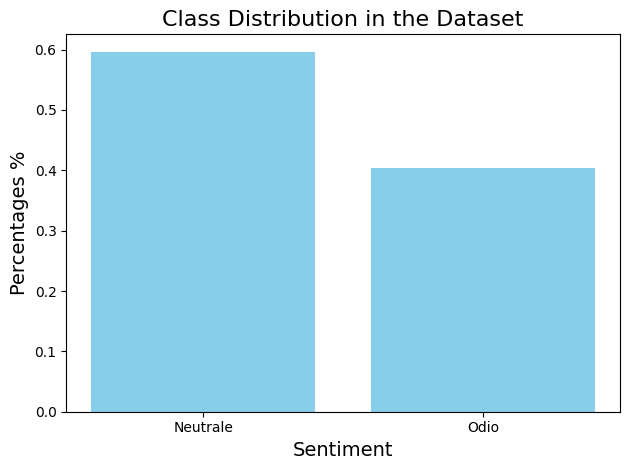

In [115]:
plt.figure()
plt.bar(class_distribution['Sentiment'], class_distribution['Percentage'], color='skyblue')
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Percentages %', fontsize=14)
plt.title('Class Distribution in the Dataset', fontsize=16)
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [116]:
test_news_df = load_jsonl_to_df(test_news_path)
# Apply to all tweets
test_news_df['text'] = test_news_df["text"].apply(standardize_tweets)

# Analyze class distribution
class_distribution = test_news_df['label'].value_counts(normalize=True).reset_index()  # normalized to show percentages

class_distribution.columns = ['Sentiment', 'Percentage']

class_distribution['Sentiment'] = ['Neutrale', 'Odio']
class_distribution

Sentiment  Percentage
0  Neutrale       0.638
1      Odio       0.362

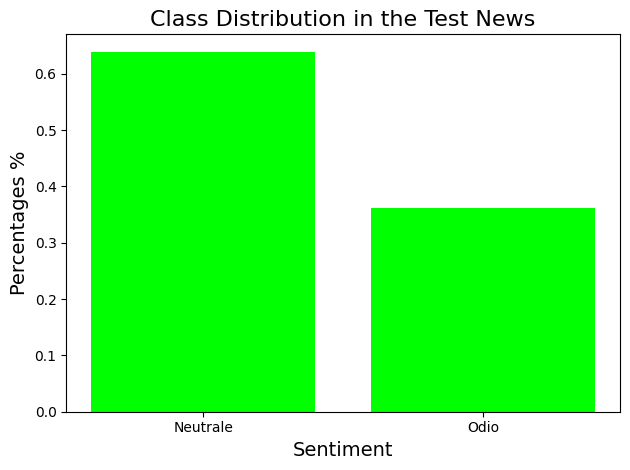

In [117]:
plt.figure()
plt.bar(class_distribution['Sentiment'], class_distribution['Percentage'], color='lime')
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Percentages %', fontsize=14)
plt.title('Class Distribution in the Test News', fontsize=16)
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [118]:
test_tweets_df = load_jsonl_to_df(test_tweets_path)
# Apply to all tweets
test_tweets_df['text'] = test_tweets_df["text"].apply(standardize_tweets)

# Analyze class distribution
class_distribution = test_tweets_df['label'].value_counts(normalize=True).reset_index()  # normalized to show percentages

class_distribution.columns = ['Sentiment', 'Percentage']

class_distribution['Sentiment'] = ['Neutrale', 'Odio']
class_distribution

Sentiment  Percentage
0  Neutrale    0.507522
1      Odio    0.492478

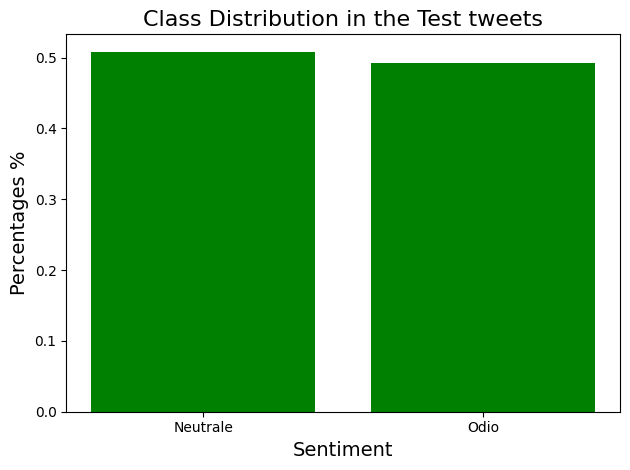

In [119]:
plt.figure()
plt.bar(class_distribution['Sentiment'], class_distribution['Percentage'], color='green')
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Percentages %', fontsize=14)
plt.title('Class Distribution in the Test tweets', fontsize=16)
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

### Text Length Analysis


* Inform preprocessing decisions, like padding or truncation, for neural network input.
* The analysis helps in managing varying text lengths, which can affect model training and performance.




Word count offers insights into the linguistic structure and content density while character count helps understand spacing, punctuation, and encoding complexities.

In [120]:
# Analyze text lengths
text_len = pd.DataFrame(columns = ['text_length_words', 'text_length_chars'])

text_len['text_length_words'] = train_df['text'].apply(lambda x: len(x.split()))
text_len['text_length_chars'] = train_df['text'].apply(len)

text_len

text_length_words  text_length_chars
0                    19                120
1                    17                101
2                    12                 86
3                    20                118
4                    20                138
...                 ...                ...
6834                 45                285
6835                 45                277
6836                 36                233
6837                 38                206
6838                 42                285

[6839 rows x 2 columns]

The average length suggests that the majority of text samples are concise, likely due to the dataset's social media origin.
The presence of outliers can skew the model's ability to learn from the more typical, shorter texts.

In [121]:
# Basic statistics for text lengths in words
average_length_words = text_len['text_length_words'].mean()
max_length_words = text_len['text_length_words'].max()  # possible outlier

print(f"Average Length in Words: {average_length_words}")
print(f"Maximum Length in Words: {max_length_words}")

Average Length in Words: 23.373007749671004
Maximum Length in Words: 94


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


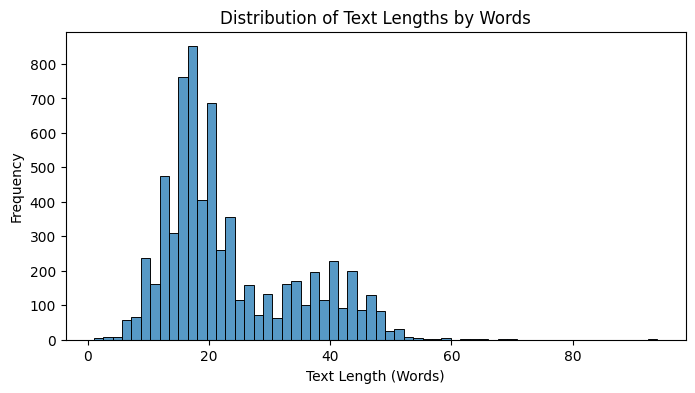

In [122]:
# Plot histogram of text lengths in words
plt.figure(figsize=(8, 4))
sns.histplot(text_len['text_length_words'], bins=60)
plt.title('Distribution of Text Lengths by Words')
plt.xlabel('Text Length (Words)')
plt.ylabel('Frequency')
plt.show()

In [123]:
# Basic statistics for text lengths in characters
average_length_chars = text_len['text_length_chars'].mean()
max_length_chars = text_len['text_length_chars'].max()
print(f"Average Length in Characters: {average_length_chars}")
print(f"Maximum Length in Characters: {max_length_chars}")

Average Length in Characters: 148.07501096651558
Maximum Length in Characters: 581


Both distributions are right-skewed, indicating that most texts are short, with a few much longer samples.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


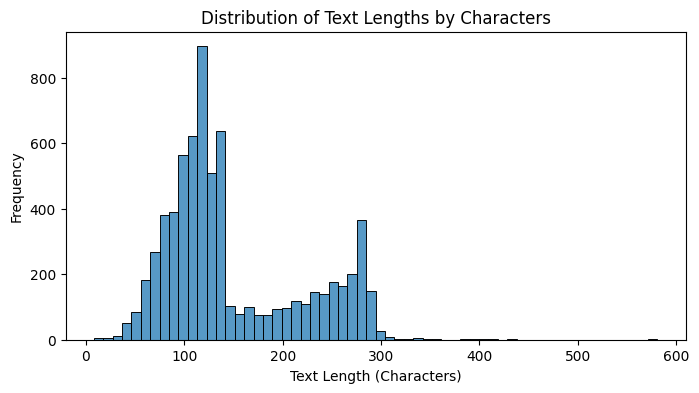

In [124]:
# Plot histogram of text lengths in characters
plt.figure(figsize=(8, 4))
sns.histplot(text_len['text_length_chars'], bins=60)
plt.title('Distribution of Text Lengths by Characters')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

The peaks indicate the most common text lengths, providing a target range for standardizing input sizes.

**Reminders** to improve quality:
- *Truncation*: cutting off texts longer than a set threshold to reduce the impact of outliers.
- *Padding*: shorter texts can be padded to ensure uniform input length for the model.
- *Outlier Analysis*: reviewing outlier content could inform whether these samples are anomalies or contain valuable information.

vedere se outlier sono neutrali o hateful

In [125]:
# Filter tweets with more than 60 words
outliers = text_len[text_len['text_length_words'] > 60]

# Merge with the original DataFrame to get the labels
outliers_with_labels = outliers.merge(train_df, left_index=True, right_index=True, how='left')

# Now select only the necessary columns to see the text and label
outliers_with_labels = outliers_with_labels[['text', 'label', 'text_length_words', 'text_length_chars']]


In [126]:
label_dict = {0: 'Neutrale', 1: 'Odio'}

# Count the number of each type of label in the outliers
label_counts = outliers_with_labels['label'].value_counts().reset_index()


# Map the numeric labels to string labels
label_counts['label'] = label_counts['label'].map(label_dict)

print("Label Distribution among outliers (more than 60 words):")
label_counts

Label Distribution among outliers (more than 60 words):


label  count
0      Odio      6
1  Neutrale      1

Since they are hateful, they must be kept. Let's analyze them further.

In [127]:
# Print some example outliers
print("Examples of outlier tweets:")
outliers_with_labels[['text', 'label']]


Examples of outlier tweets:


text  label
4342  @user @user @user @user @user @user @user @use...      1
4803  @user @user @user @user @user @user @user @use...      0
5124  @user @user @user @user @user @user @user @use...      1
5690  @user @user @user @user @user @user @user @use...      1
5873  @user @user @user @user @user @user @user @use...      1
5880  @user @user @user @user @user @user @user @use...      1
5926  @user @user @user @user @user @user @user @use...      1

In [128]:
idxs = [4342, 4803, 5124, 5690, 5873, 5880, 5963]
for i, row in outliers_with_labels.iterrows():
    print(row["text"], end="\n\n")

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Ricordo per inciso che da decenni ormai i Rom sono intoccabili.illegalità totale impunità etc.etc possono finire in carcere solo dopo una decina di condanne, da anni guidano senza patente e assicurazione e chi viene investito sono cazzi suoi........amen 

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Come?? La pacchia non doveva finire per gli immigrati? E il reddito di cittadinanza? E quota 100? 

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @u

Moreover, after user handles (@user) will be removed, these will not be outliers anymore, thus problem solved. It's interesting to notice though that the only neutral sentence may be also interpreted as hateful. That's why it's hard to classify sentences in one way or another. It's a subjective matter.

### Vocabulary analysis



The frequency of words like '@user' and 'URL' suggests common placeholders that might need to be removed or replaced because they likely do not contribute to understanding the sentiment of the text. The prevalence of common Italian stopwords and prepositions ('e', 'di', 'che', ...) suggests that removing or retaining stopwords could be an important preprocessing step to focus the model on more meaningful words, especially for the baseline model.

In [129]:
all_words = [word.lower() for text in train_df['text'] for word in text.split()]
word_counts = Counter(all_words)
vocabulary_size = len(word_counts)
most_common_words = word_counts.most_common(20)

print(f"Vocabulary Size: {vocabulary_size}")
print("Most Common Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

Vocabulary Size: 30245
Most Common Words:
@user: 4663
e: 4106
di: 4087
url: 3504
che: 2945
i: 2890
a: 2773
in: 2265
il: 2243
la: 2212
non: 2131
per: 1870
è: 1596
un: 1298
gli: 1201
sono: 1182
le: 1038
rom: 1004
con: 990
da: 981


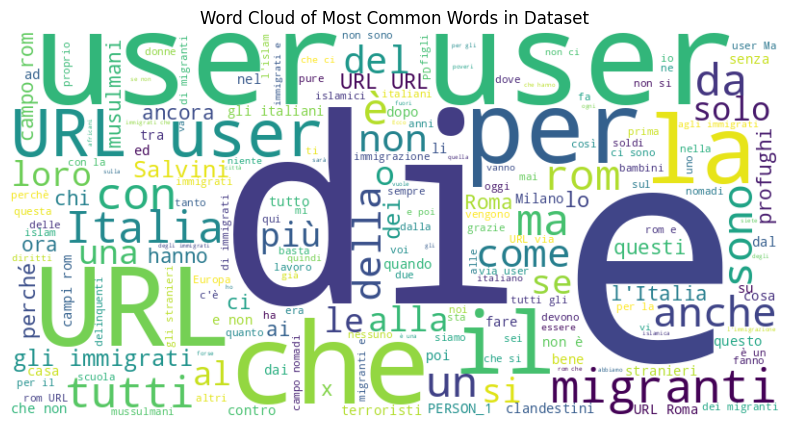

In [130]:
# Collect all text data into one large string
text = ' '.join(train_df['text'])

# Create a word cloud object
wordcloud = WordCloud(width = 800, height = 400, background_color ='white',
                          max_words=200, contour_width=3, contour_color='steelblue').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Word Cloud of Most Common Words in Dataset')
plt.show()

It's fundamental to analyze also strange characters, in order to understand if they should be kept, discarded or replaced.

The result is extremely valuable. Of course, speaking of italian language, accented characters are extremely important and can alter the meaning of words if removed. Certain punctuation characters are can be significant for understanding the structure of sentences and, by extension, the sentiment or emphasis in the text (e.g., exclamation marks may indicate strong emotion). Curly quotes and dashed should be standardized (e.g., “,”,’,\`, all to ').
Emojis are increasingly used to express emotions and can be quite informative for sentiment analysis and hate speech detection. For example, 😡 may indicate anger or frustration, which is relevant in the context of hate speech. Thus, they will be converted to a textual representation that captures their sentiment (like faccina_arrabbiata).

Other punctuation marks like angle brackets (< >) or pipes (|), currency symbols (€), percentages (%) could be removed since they do not contribute to the task.

Twitter handles '@' and hashtags '#', and characters like �, which typically represent encoding errors, should be investigated further.

In [131]:
a = train_df['text'].apply(lambda x: count_target_characters(x, patterns = "#"))

# Find the tweet with the highest count of # characters
max_target_char_tweet = train_df.loc[a.idxmax()]

print("Changed chars ", a.max(), "idx", a.idxmax())
max_target_char_tweet["text"]

Changed chars  18 idx 4173


'#barbarians #primitive e basta! Senza se e senza ma! #StopIslam #StopImmigration #immigrazione #immigrati #stopinvasione #pdnetwork #Boldrini #StopInvasion #complicediSalvini #iostoconsalvini #NessunoTocchiSalvini #clandestini #razzismo #WilPopoloItaliano #wlitalia #aCalciInCulo '

In [132]:
# Regular expression pattern to match common characters:
# This includes ASCII letters, digits, common punctuation, and whitespace.
# You can adjust it to include any additional characters you consider 'normal'.

# Function to find strange characters
def find_strange_characters(text):
    normal = "a-zA-Z0-9"
    accented_letters = "àèéìòùÀÈÉÒÙ"
    punctuation = re.escape('\\') + ",.!?;:<>#/'\"…-"
    normal_chars_pattern = f"[\s{normal}{accented_letters}{punctuation}]+"
    # Find all characters that are NOT in the normal pattern
    strange_chars = re.sub(normal_chars_pattern, '', text)
    return strange_chars

# Apply the function to each text entry and collect the strange characters
all_strange_characters = ''.join(train_df['text'].apply(find_strange_characters))

# Count the occurrences of each strange character
strange_char_counter = Counter(all_strange_characters)

# Sort and print the most common strange characters
print(f"Number of strange characters: {len(strange_char_counter.keys())}")
for char, count in strange_char_counter.most_common():
    print(f"Character: {char} | Occurrences: {count}")


Number of strange characters: 203
Character: @ | Occurrences: 4727
Character: ) | Occurrences: 412
Character: ( | Occurrences: 396
Character: _ | Occurrences: 211
Character: � | Occurrences: 173
Character: « | Occurrences: 112
Character: » | Occurrences: 106
Character: % | Occurrences: 91
Character: + | Occurrences: 85
Character: 😡 | Occurrences: 70
Character: | | Occurrences: 68
Character: 😂 | Occurrences: 57
Character: € | Occurrences: 47
Character: ️ | Occurrences: 42
Character: * | Occurrences: 37
Character: 🇮 | Occurrences: 37
Character: 🇹 | Occurrences: 36
Character: & | Occurrences: 36
Character: 👎 | Occurrences: 32
Character: • | Occurrences: 29
Character: 🤣 | Occurrences: 27
Character: 😁 | Occurrences: 25
Character: 🤔 | Occurrences: 23
Character: 💩 | Occurrences: 23
Character: = | Occurrences: 19
Character: ] | Occurrences: 18
Character: [ | Occurrences: 17
Character: 👍 | Occurrences: 16
Character: 😠 | Occurrences: 14
Character: 👿 | Occurrences: 14
Character: 👏 | Occurrences: 

In [133]:
least_frequents = ''
for char, count in strange_char_counter.most_common()[::-1]:
    # print(f"Character: {char} | Occurrences: {count}")
    if count>3:
      break
    least_frequents += char

least_frequents

'😪🐜⬇🎄😯🔫🙏👕„📖🌏☹⭐🤐🏐⛅🐓🐖🍺🍷✝☪⌨🦅👊😩！📌✍ℹ🇫👈🔽📺📢📆✂🌹🚫💔😫👋😟🤚Å↪🤪🍸💬😥🖒ĺ🕋🤡🕌💣â\x94\x93👹ë👌مالس🇧🇬🤓аоІ🏼ā🙂🏾×💚⚡🤫♂👀▪🖊➡🇷ø✋😘😐✊🌈⁉🤨🌍😜📍~🌿ʼ💖😅►🔥ė—❤♻✳і😲😆💃Ì😬🏿\u200b^😒💥⛔😊😉🤕í▶е☺😑🇾🇸'

In [134]:
def find_texts_with_character(df, character, b=False):
    # Filter the DataFrame for texts containing the specific character
    contains_char_df = df[df['text'].str.contains(character, regex=b)]
    return contains_char_df['text'].tolist()

# Assuming 'train_df' is your DataFrame and it has a column 'text' that contains the text entries
texts_with_char = find_texts_with_character(train_df, ' 🏻') # … <PERSON_1>

# This will print out all texts that contain the character '�'
for text in texts_with_char:
    print(text)


In [135]:
def remove_characters(text):
    # Remove @user.
    # text = re.sub(r'@user', '', text)
    # Since there are some non-renamed users, (i. e. @M_decimoMeridio, @OllaPiero, @ibico75, @Noiconsalvini:, @indivanados:, @rossbova])
    # Remove usernames: any string that starts with @ and continues until a space or punctuation
    text = re.sub(r'@\w+\b', ' ', text)

    # Remove URLs, case-insensitive
    text = re.sub(r'url', ' ', text, flags=re.IGNORECASE)

    # Remove non-frequent characters
    text = re.sub(f'[{re.escape(least_frequents)}]', ' ', text)

    # Remove variation selectors and other non-visible characters, like U+FE0F Variation Selector-16 and Zero Width Joiner
    text = regex.sub(r'[\u200D|\uFE0F]', ' ', text)

    # Remove useless punctuation
    text = re.sub(r'[()\[\]«»|�*&_•° 🏻]+', ' ', text)
    text = re.sub(r"\s+", ' ', text)

    return text.strip()

In [136]:
train_df['text'] = train_df['text'].apply(lambda x: remove_characters(x))

In [137]:
all_strange_characters = ''.join(train_df['text'].apply(find_strange_characters))

strange_char_counter = Counter(all_strange_characters)

print(f"Number of strange characters: {len(strange_char_counter.keys())}")
chars = []
for char, count in strange_char_counter.most_common():
    print(f"Character: {char}, {ord(char)} | Occurrences: {count}")
    chars.append(char)

Number of strange characters: 55
Character: %, 37 | Occurrences: 91
Character: +, 43 | Occurrences: 85
Character: 😡, 128545 | Occurrences: 70
Character: 😂, 128514 | Occurrences: 57
Character: €, 8364 | Occurrences: 47
Character: 🇮, 127470 | Occurrences: 37
Character: 🇹, 127481 | Occurrences: 36
Character: 👎, 128078 | Occurrences: 32
Character: 🤣, 129315 | Occurrences: 27
Character: 😁, 128513 | Occurrences: 25
Character: 🤔, 129300 | Occurrences: 23
Character: 💩, 128169 | Occurrences: 23
Character: =, 61 | Occurrences: 19
Character: 👍, 128077 | Occurrences: 16
Character: 😠, 128544 | Occurrences: 14
Character: 👿, 128127 | Occurrences: 14
Character: 👏, 128079 | Occurrences: 13
Character: 🤮, 129326 | Occurrences: 13
Character: 😭, 128557 | Occurrences: 13
Character: 🙄, 128580 | Occurrences: 11
Character: 😤, 128548 | Occurrences: 11
Character: 🤦, 129318 | Occurrences: 11
Character: 🖕, 128405 | Occurrences: 10
Character: 😳, 128563 | Occurrences: 9
Character: 😄, 128516 | Occurrences: 9
Characte

In [138]:
def calculate_char_frequencies(df, strange_characters):
    # Initialize a dictionary to hold frequencies
    char_frequencies = {char: {'neutrale': 0, 'odio': 0} for char in strange_characters}

    # Count occurrences of each character in each class
    for char in strange_characters:
        for index, row in df.iterrows():
            if char in row['text']:
                label = 'neutrale' if row['label'] == 0 else 'odio'
                char_frequencies[char][label] += 1

    # Normalize by the number of sentences in each class
    total_neutrale = len(df[df['label'] == 0])
    total_odio = len(df[df['label'] == 1])
    for char in char_frequencies:
        char_frequencies[char]['neutrale'] /= total_neutrale
        char_frequencies[char]['odio'] /= total_odio

    return char_frequencies

# Calculate frequencies
frequencies = calculate_char_frequencies(train_df, chars)
frequencies

{'%': {'neutrale': 0.011293886570095753, 'odio': 0.012653651482284888},
 '+': {'neutrale': 0.005155904738521974, 'odio': 0.008315256688358641},
 '😡': {'neutrale': 0.001718634912840658, 'odio': 0.007592190889370932},
 '😂': {'neutrale': 0.0027007120058924624, 'odio': 0.004699927693420101},
 '€': {'neutrale': 0.00441934691873312, 'odio': 0.007592190889370932},
 '🇮': {'neutrale': 0.0027007120058924624, 'odio': 0.005061460592913955},
 '🇹': {'neutrale': 0.0024551927326295114, 'odio': 0.005061460592913955},
 '👎': {'neutrale': 0.0012275963663147557, 'odio': 0.0025307302964569776},
 '🤣': {'neutrale': 0.0012275963663147557, 'odio': 0.0021691973969631237},
 '😁': {'neutrale': 0.0012275963663147557, 'odio': 0.0025307302964569776},
 '🤔': {'neutrale': 0.0027007120058924624, 'odio': 0.0032537960954446853},
 '💩': {'neutrale': 0.00024551927326295114, 'odio': 0.0039768618944323935},
 '=': {'neutrale': 0.0024551927326295114, 'odio': 0.0025307302964569776},
 '👍': {'neutrale': 0.0009820770930518046, 'odio':

In [139]:
emoji.demojize("🇪🇺", delimiters=(" ", " "), language='it')

' bandiera_unione_europea '

In [140]:
len(frequencies)

55

In [141]:
def plot_freq_strange_char(start=0, end=10, xlabels=None):

    f = dict(list(frequencies.items())[start:end])
    freq_df = pd.DataFrame(f).transpose()

    # Plotting the bar chart using the specified font
    ax = freq_df.plot(kind='bar', figsize=(15, 5), legend=True)
    plt.title('Frequency of Strange Characters by Class')
    plt.xlabel('Characters')
    plt.ylabel('Normalized Frequency')

    # Set custom x-labels if provided
    if xlabels:
        ax.set_xticklabels(xlabels, rotation=90)  # Rotate labels if needed

    plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127481 (\N{REGIONAL INDICATOR SYMBOL LETTER T}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128078 (\N{THUMBS DOWN SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt

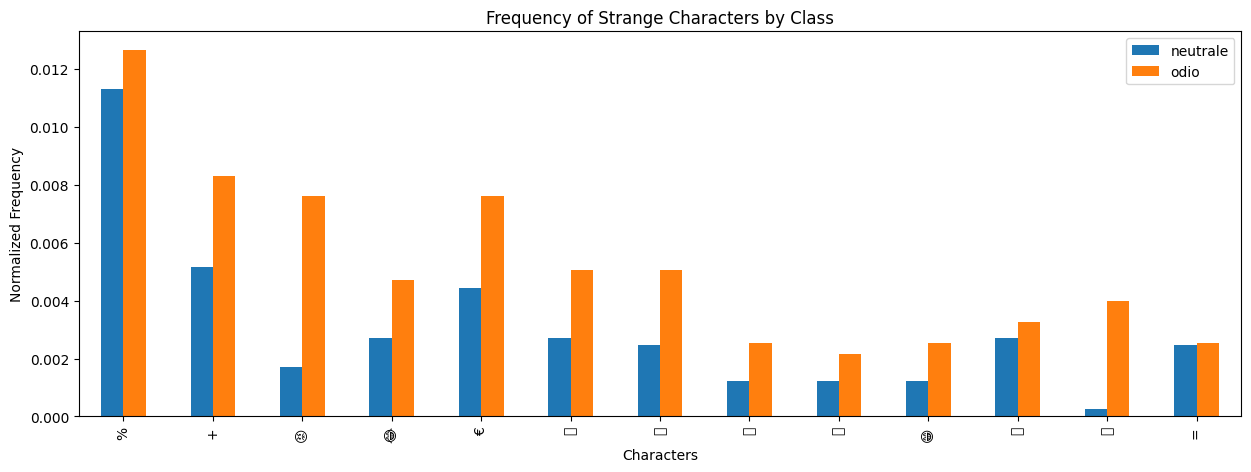

In [142]:
xlabels = ["%", "+", "😡", "😂️", "€", "🇮", "🇹", "👎", "🤣", "😁", "🤔", "💩", "="]
plot_freq_strange_char(0, 13, xlabels)

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128127 (\N{IMP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129326 (\N{FACE WITH OPEN MOUTH VOMITING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPy

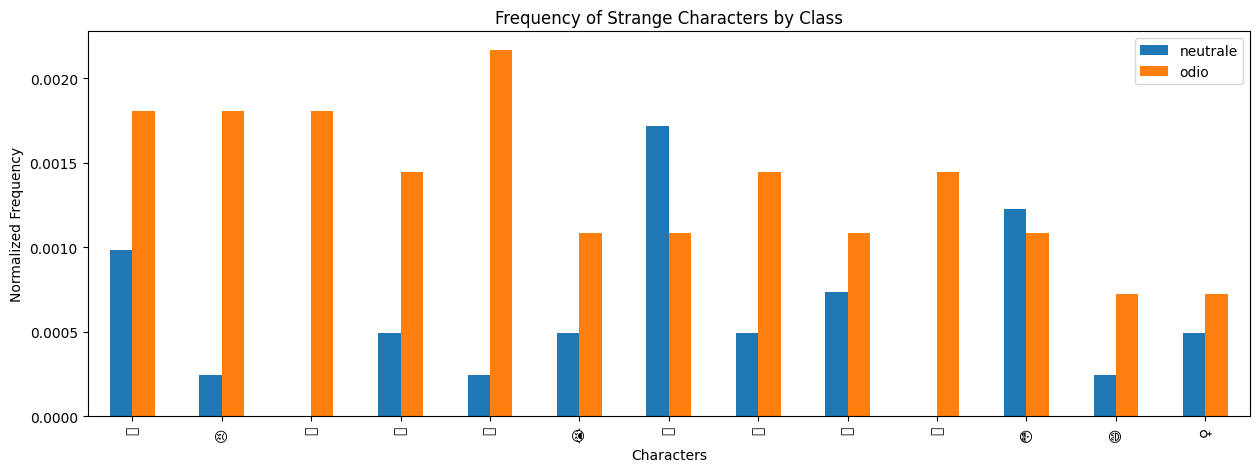

In [143]:
xlabels = ["👍", "😠", "👿", "👏", "🤮️", "😭", "🙄", "😤", "🤦", "🖕", "😳"]
plot_freq_strange_char(13, 26)

In [144]:
!pip install emoji > /dev/null

In [145]:
train_df['text'].iloc[149]

'E qui non possiamo dire che temiamo gli islamici, sennò siamo "razzisti"... 😠'

In [146]:
train_df['text'].iloc[630]

'La Meloni pensava che i media dicessero ?😄😄😄 Come i terroristi ? Tutti malati mentali 😄😄😄'

In [147]:
train_df['text'].iloc[212]

'La stampa Britannica che è serissima dice che il parlamentare #StevenWoolfe è in fin di vita. Rissa per via dei #migranti 🙄'

In [148]:
import emoji

def convert_emojis_to_text(text):
    text = emoji.demojize(text, delimiters=(" ", " "), language='it')
    text = re.sub(r'_', ' ', text)
    text = re.sub(r"\s+", ' ', text)
    
    return text.strip()

train_df['text'] = train_df['text'].apply(lambda x: convert_emojis_to_text(x))

In [149]:
train_df['text'].iloc[149]

'E qui non possiamo dire che temiamo gli islamici, sennò siamo "razzisti"... faccina arrabbiata'

In [150]:
train_df['text'].iloc[630]

'La Meloni pensava che i media dicessero ? faccina con sorriso e occhi sorridenti faccina con sorriso e occhi sorridenti faccina con sorriso e occhi sorridenti Come i terroristi ? Tutti malati mentali faccina con sorriso e occhi sorridenti faccina con sorriso e occhi sorridenti faccina con sorriso e occhi sorridenti'

In [151]:
train_df['text'].iloc[212]

'La stampa Britannica che è serissima dice che il parlamentare #StevenWoolfe è in fin di vita. Rissa per via dei #migranti faccina con occhi al cielo'

# Non-trivial baseline model

#### Remove digits

In [152]:
def rem_digits(text):
    '''Function to remove the digits from the list of strings'''
    text = re.sub(r'\d','',text)
    return text

In [153]:
non_trivial_df = train_df.copy(deep=True)
non_trivial_df['text'] = non_trivial_df['text'].apply(rem_digits)

### Remove special characters

In [154]:
non_trivial_df['text'].iloc[2999]

'Ancora i rom???la feccia della feccia...ladri..spacciatori..prostituzione ....Da cacciare tutti... #tagadala'

In [155]:
for i in range(30,40):
    print(non_trivial_df['text'].iloc[i])

Pesaro, polizia allontana tre rom dal Parco XXV aprile - Pesaro,  novembre  - Operazione della Questura, ...
Rubano oro e gioielli in abitazione del Centro storico, denunciate due rom, una minorenne: leggi tutto l'articolo
Siria, Assad: "La guerra finirà quando elimineremo tutti i terroristi" Mediaset
E occhio che molti furbacchioni, trasformano in profughi anche coloro che ottengono protezione sussidiaria..
#Roma, arrestato rapinatore #nomade #latitante dal 
Roma città - Chiusura campo rom posticipata, si tenta il dialogo - Cittaceleste.it #Roma
e aggiungo, xké non lo ha fatto x clandestini rom iussoli stranieri criminali UE e € ? Parole parole
Hanno fatto bene.Questi stranieri che hanno occupato tutti i posti per far giocare i ns.giovani,da dove vengono?Dalla feccia.
ma davero? Dici che i nomadi non si rassegnano all'idea che è arrivata Sora #Raggi? è incredibile...ci vorrebbe Bep…
Roma, campi rom da chiudere entro il  gennaio : il piano del Campidoglio - Il Messaggero #Roma #news


In [156]:
non_trivial_df['text'].iloc[38]

"ma davero? Dici che i nomadi non si rassegnano all'idea che è arrivata Sora #Raggi? è incredibile...ci vorrebbe Bep…"

In [157]:
non_trivial_df['text'].iloc[13]

'Rischiando di essere presa per pazza che non sa di cosa parla#Trump dopo i musulmani e i gay.quelli di colore?#benvenutoHitler?#preoccupante'

In [158]:
def rem_nonalpha(text):
    '''Function to remove the non-alphanumeric characters from the text'''
    text = re.sub(r'€', ' euro ', text)
    text = re.sub(r'\$', ' dollari ', text)
    text = re.sub(r'%', ' percento ', text)
    text = re.sub(r'\+', ' più ', text)
    text = re.sub(r'=', ' uguale ', text)
    text = re.sub(r'\W', ' ', text) # remove any non-alphanumeric character
    text = re.sub(r'\s+', ' ', text) # map additional spaces to a single one
    return text.strip()

In [159]:
#remove the non alpha numeric characters from the tweet tokens
non_trivial_df['text'] = non_trivial_df['text'].apply(rem_nonalpha)

In [160]:
non_trivial_df['text'].iloc[2999]

'Ancora i rom la feccia della feccia ladri spacciatori prostituzione Da cacciare tutti tagadala'

In [161]:
non_trivial_df['text'].iloc[13]

'Rischiando di essere presa per pazza che non sa di cosa parla Trump dopo i musulmani e i gay quelli di colore benvenutoHitler preoccupante'

In [162]:
non_trivial_df['text'].iloc[37]

'Hanno fatto bene Questi stranieri che hanno occupato tutti i posti per far giocare i ns giovani da dove vengono Dalla feccia'

#### Remove stopwords

In [163]:
!python3 -m spacy download it_core_news_sm > /dev/null

In [164]:
!python3 -m spacy download it_core_news_md > /dev/null

In [165]:
# Load the Italian language model
spacy.prefer_gpu()
nlp = spacy.load("it_core_news_sm", enable = ["tokenizer"]) #exclude=['parser', 'ner', 'lemmatizer', 'tagger', 'morphologizer', 'senter'])

additional_stopwords = set([""])

# additional_stopwords.update({'piacere', 'salve', 'buongiorno', 'benvenuto', 'benvenuta', 'buonasera', 'buonanotte', 'bentornato', 'bentornata'})

# Get the default Italian stopwords from spaCy
# italian_stopwords = set(spacy.lang.it.stop_words.STOP_WORDS)
italian_stopwords = set(nltk_stopwords.words('italian'))

italian_stopwords.update(additional_stopwords)

print(len(italian_stopwords))

280


In [166]:
# nltk_stopwords.words('italian')

In [167]:
def tokenize_italian_nostop(text):
    doc = nlp(text.strip().lower())
    tokens = []
    for token in doc:
        if token.text not in italian_stopwords:
            if token.text in string.punctuation and tokens and tokens[-1] not in string.punctuation:
                tokens.append(token.text)
            else:
              tokens.append(token.text)

    if tokens[0] in string.punctuation:
      del tokens[0]
    return tokens

# Apply the tokenizer to each entry in the DataFrame
non_trivial_df['tokens_nostopwords'] = non_trivial_df['text'].apply(tokenize_italian_nostop)


In [168]:
non_trivial_df.head()

text           choices  label  \
0  È terrorismo anche questo per mettere in uno s...  [neutrale, odio]      0   
1  infatti finché ci hanno guadagnato con i campi...  [neutrale, odio]      0   
2  Corriere Tangenti Mafia Capitale dimenticataMa...  [neutrale, odio]      0   
3  ad uno ad uno perché quando i migranti israeli...  [neutrale, odio]      0   
4  Il divertimento del giorno Trovare i patrioti ...  [neutrale, odio]      0   

                                  tokens_nostopwords  
0  [terrorismo, mettere, stato, soggezione, perso...  
1  [infatti, finché, guadagnato, campi, rom, ok, ...  
2  [corriere, tangenti, mafia, capitale, dimentic...  
3  [quando, migranti, israeliti, arrivarono, terr...  
4  [divertimento, giorno, trovare, patrioti, ital...

### Comparison with tokenizer on raw text

In [169]:
def tokenize_italian(text):
    text = text.strip()
    text = text[0].title()+text[1:]
    # Process the text with the NLP model
    doc = nlp(text)
    # Extract tokens from the doc
    tokens = [token.text for token in doc]
    return tokens

# Apply the tokenizer to each entry in the DataFrame
train_df['tokens'] = train_df['text'].apply(tokenize_italian)
train_df.tail(5)


text           choices  \
6834  Gli stati nazionali devono essere pronti a rin...  [neutrale, odio]   
6835  Il ministro dell'interno della Germania #Horst...  [neutrale, odio]   
6836  #Salvini: In Italia troppi si sono montati la ...  [neutrale, odio]   
6837  Chi giubila in buona fede non ha capito niente...  [neutrale, odio]   
6838  I giovani cristiani in #Etiopia sono indotti d...  [neutrale, odio]   

      label                                             tokens  
6834      0  [Gli, stati, nazionali, devono, essere, pronti...  
6835      0  [Il, ministro, dell', interno, della, Germania...  
6836      0  [#, Salvini, :, In, Italia, troppi, si, sono, ...  
6837      0  [Chi, giubila, in, buona, fede, non, ha, capit...  
6838      0  [I, giovani, cristiani, in, #, Etiopia, sono, ...

### Check Wordcloud

In [170]:
# join the words in each tweet for visualization
non_trivial_df['tokens_nostopwords'] = non_trivial_df['tokens_nostopwords'].apply(lambda x: " ".join(x))
non_trivial_df['tokens_nostopwords']

0       terrorismo mettere stato soggezione persone re...
1       infatti finché guadagnato campi rom ok alemann...
2       corriere tangenti mafia capitale dimenticatama...
3       quando migranti israeliti arrivarono terra can...
4       divertimento giorno trovare patrioti italiani ...
                              ...                        
6834    stati nazionali devono essere pronti rinunciar...
6835    ministro interno germania horstseehofer propos...
6836    salvini italia troppi montati testa ringrazio ...
6837    giubila buona fede capito niente purtroppo cre...
6838    giovani cristiani etiopia indotti islamisti co...
Name: tokens_nostopwords, Length: 6839, dtype: object

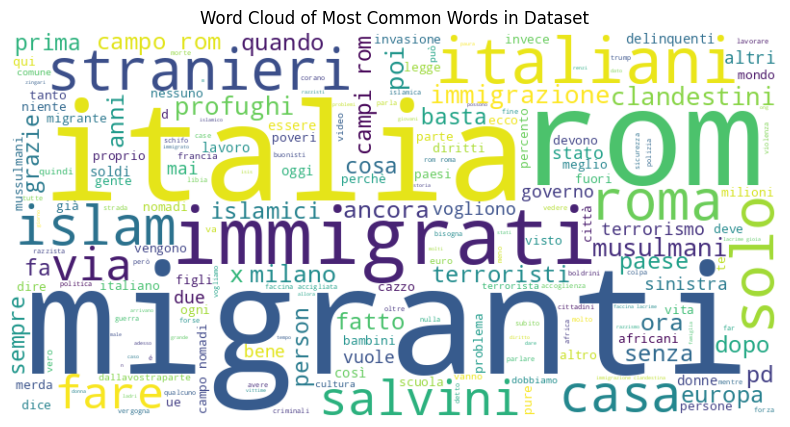

In [171]:
# Collect all text data into one large string
text = ' '.join(non_trivial_df['tokens_nostopwords'])

# Create a word cloud object
wordcloud = WordCloud(width = 800, height = 400, background_color ='white',
                          max_words=200, contour_width=3, contour_color='steelblue').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Word Cloud of Most Common Words in Dataset')
plt.show()

## Model

### Train-validation splitting

In [206]:
# Split data into input X and output y
X = non_trivial_df['tokens_nostopwords']
y = non_trivial_df['label']

Using a single train-validation split just for simplicity. Later a k-fold avalidation strategy will be adopted.

In [207]:
# Split the data in train and val
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=23,stratify=non_trivial_df['label'])
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(5471,) (1368,) (5471,) (1368,)


In [174]:
X_train[8], y_train[8]

('smettetela dire italiani stati migranti trattati male uccidevano innocenti strada',
 0)

In [175]:
X_train.head()

5090    campi rom milano austria accompagnati confine ...
5011                         pietre petardi case migranti
2243    piccola nota alcune popolazioni rom italia ann...
4928    immigrazioni iran multilateralismo duello onu ...
6791    sicuri islam dietro balordi comincio pensare q...
Name: tokens_nostopwords, dtype: object

### Tf-idf

Now use tf-idf as a feature to get into the vector space model

In [208]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=2,
                                   sublinear_tf=True)

In [209]:
# fit on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# transform the test data
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# check the shape
X_train_tfidf.shape, X_val_tfidf.shape

((5471, 6501), (1368, 6501))

In [213]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=2)

tf_matrix = count_vect.fit_transform(X_train)
tf_matrix.shape

(5471, 6501)

In [214]:
train_tfidf_df = pd.DataFrame(data={'word': tfidf_vectorizer.get_feature_names_out(), # 
                                    'tf': tf_matrix.sum(axis=0).A1,
                                    'idf': tfidf_vectorizer.idf_,
                                    'tfidf': X_train_tfidf.sum(axis=0).A1 # Al is needed to convert the matrix into a regular array
                   }).sort_values(['tfidf', 'idf'], ascending=False) # sort by TFIDF, then TF, then IDF
train_tfidf_df.head(10)

word    tf       idf       tfidf
5044           rom  1229  2.532436  168.804397
3488      migranti  1039  2.708685  134.972051
3012        italia   887  2.888386  127.997354
2711     immigrati   826  2.930316  115.999173
5045          roma   511  3.452541   95.607691
3015      italiani   484  3.487102   74.692808
5742     stranieri   381  3.704766   68.171764
2714  immigrazione   375  3.699317   63.717506
6326           via   294  3.958425   62.863483
857          campo   257  4.066136   58.184222

### Ordinary Logistic Regression

In [180]:
from sklearn.linear_model import LogisticRegression

In [181]:
# default hyper-parameters
clf = LogisticRegression()
clf.fit(X_train_tfidf,y_train)
train_predictions = clf.predict(X_train_tfidf)
val_predictions = clf.predict(X_val_tfidf)

### Model evaluation

In [182]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as auc_func


In [183]:
# get the model accuracy on the training and the test set
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_val,val_predictions))

# classification report
print('Classification Report Training set')
print('\n')
print(classification_report(y_train,train_predictions))

print('Classification Report Testing set')
print('\n')
print(classification_report(y_val,val_predictions))

Accuracy Score on training set 0.87187
Accuracy Score on test set 0.75585
Classification Report Training set


              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3258
           1       0.90      0.77      0.83      2213

    accuracy                           0.87      5471
   macro avg       0.88      0.86      0.86      5471
weighted avg       0.87      0.87      0.87      5471

Classification Report Testing set


              precision    recall  f1-score   support

           0       0.76      0.85      0.81       815
           1       0.74      0.61      0.67       553

    accuracy                           0.76      1368
   macro avg       0.75      0.73      0.74      1368
weighted avg       0.75      0.76      0.75      1368



### Weighted Logistic Regression

In [184]:
#define the weight of the class labels using inverse ratio
weights = {0:1.0,1:1.5}

#instantiate the logistic regression model and account for the weights to be applied for model coefficients update magnitude
clf = LogisticRegression(solver='lbfgs',class_weight=weights)

#fit and predict
clf.fit(X_train_tfidf,y_train)
train_predictions = clf.predict(X_train_tfidf)
val_predictions = clf.predict(X_val_tfidf)

# get the model accuracy on the training and the test set
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_val,val_predictions))

#classification report
print('Classification Report Training set')
print('------------------------------------')
print('\n')
print(classification_report(y_train,train_predictions))
print('\n')

print('Classification Report Testing set')
print('------------------------------------')
print('\n')
print(classification_report(y_val,val_predictions))

Accuracy Score on training set 0.88521
Accuracy Score on test set 0.76023
Classification Report Training set
------------------------------------


              precision    recall  f1-score   support

           0       0.94      0.87      0.90      3258
           1       0.82      0.91      0.87      2213

    accuracy                           0.89      5471
   macro avg       0.88      0.89      0.88      5471
weighted avg       0.89      0.89      0.89      5471



Classification Report Testing set
------------------------------------


              precision    recall  f1-score   support

           0       0.82      0.77      0.79       815
           1       0.69      0.75      0.72       553

    accuracy                           0.76      1368
   macro avg       0.75      0.76      0.75      1368
weighted avg       0.77      0.76      0.76      1368



### Summary

Below you can find a summary of the non-trivial baseline model. 
* Cross-validation is being used to give a more reliable estimate of the model's performance on unseen data;
* Automatic class weighting with `class_weight='balanced'`;
* A Randomized Search has been performed to find the best hyperparameters on both the vectorizer and the logistic regression. However, since the default ones were extremely close to the optimal, to avoid the cluttering of the hyperparameters tuning the code has been removed for better clarity. The only meaningful add was the min_df variable, that ignore terms that have a document frequency less than 2, namely that are present in only 1 tweet. The term size is shrinken from 51k to just 6k.


In [185]:
from sklearn.model_selection import StratifiedKFold

X = non_trivial_df['tokens_nostopwords']
y = non_trivial_df['label']

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=2,
                                   sublinear_tf=True)

# Fit the vectorizer on the full dataset
# X_tfidf = tfidf_vectorizer.fit_transform(X)

# Logistic regression model with automatic class weight detection
clf = LogisticRegression(C=1, solver='lbfgs', penalty='l2', class_weight='balanced')

# Perform stratified k-fold cross-validation. Folds are made by preserving the percentage of samples for each class.
kf = StratifiedKFold(n_splits=10, random_state=23, shuffle=True)

# Lists to store the metrics for each fold
acc_scores, f1_scores, aucs = [], [], []

fprs, tprs = [], []

best_classification_report = None
best_f1_score = 0  # Initialize the best F1 score to the lowest possible value

# Lists to store classification reports and confusion matrices
confusion_matrices = []

# Start cross-validation process
for train_index, val_index in kf.split(X, y):
    # Split data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fit and transform the data using TfidfVectorizer
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    
    # Fit the classifier
    clf.fit(X_train_tfidf, y_train)
    
    # Predict on the validation set
    val_predictions = clf.predict(X_val_tfidf)
    # Predict probabilities on the validation set
    val_probs = clf.decision_function(X_val_tfidf)
    
    # Calculate metrics
    acc = accuracy_score(y_val, val_predictions)
    current_f1_score = f1_score(y_val, val_predictions, average='weighted')
    auc = roc_auc_score(y_val, val_probs)
    
    
    # Store classification report and confusion matrix
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_classification_report = classification_report(y_val, val_predictions)

    confusion_matrices.append(confusion_matrix(y_val, val_predictions))
    
    # Append scores, ROC curve and area under the curve
    acc_scores.append(acc)
    f1_scores.append(current_f1_score)
    aucs.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, val_probs)
    fprs.append(fpr)
    tprs.append(tpr)

# Print average of the evaluation metrics
print(f'Weighted average Accuracy across folds: {np.mean(acc_scores):.4f}')
print(f'Weighted average F1 Score across folds: {np.mean(f1_scores):.4f}')
print(f'Weighted average ROC AUC Score across folds: {np.mean(aucs):.4f}')


Weighted average Accuracy across folds: 0.7602
Weighted average F1 Score across folds: 0.7619
Weighted average ROC AUC Score across folds: 0.8403


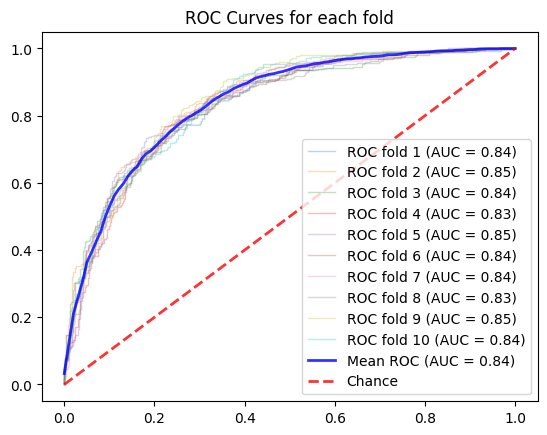

In [186]:
mean_fpr = np.linspace(0, 1, 100)

idk = []
fig, ax = plt.subplots()
for i, (fpr, tpr, roc_auc) in enumerate(zip(fprs, tprs, aucs)):
    
    # Plot ROC curve for current fold
    ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')
    idk.append(np.interp(mean_fpr, fpr, tpr))

# Plot the mean ROC
mean_tpr = np.mean(idk, axis=0)
mean_auc = auc_func(mean_fpr, mean_tpr)
ax.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=0.8)

# Plot the chance line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)

# Final plot adjustments
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curves for each fold")
ax.legend(loc="lower right")
plt.show()


In [188]:
precisions, recalls, f1s, supports = zip(*[precision_recall_fscore_support(y.iloc[val_index], clf.predict(tfidf_vectorizer.transform(X.iloc[val_index])), beta=1.0) for _, val_index in kf.split(X, y)])
#print(f1s)
idxs = [i for _, i in kf.split(X, y)]
#f1_score(y.iloc[idxs[0]], clf.predict(X_tfidf[idxs[0]]), average='weighted')
print(f'Weighted average F1 Score across folds: {np.mean(f1s):.4f}')

Weighted average F1 Score across folds: 0.8569


Classification Report with best F1 score
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       407
           1       0.71      0.74      0.73       277

    accuracy                           0.77       684
   macro avg       0.77      0.77      0.77       684
weighted avg       0.78      0.77      0.78       684



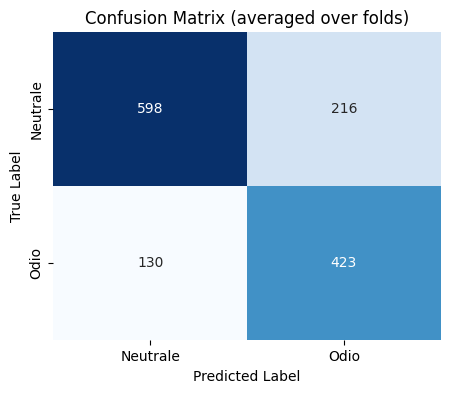

In [189]:
print('Classification Report with best F1 score')
print(best_classification_report)

# Aggregate confusion matrices
mean_confusion_matrix = np.sum(confusion_matrices, axis=0)//5

plt.figure(figsize=(5, 4))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (averaged over folds)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['Neutrale', 'Odio'])
plt.yticks([0.5, 1.5], ['Neutrale', 'Odio']) 
plt.show()

In [190]:
# Fit the vectorizer on the whole dataset
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Fit the classifier on the whole dataset
clf.fit(X_tfidf, y)

# Get the feature names
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Get the coefficients
coef = clf.coef_.flatten()

# Sort the coefficients and feature names
sorted_indices = coef.argsort()

# Get the top 10 features for both classes
top_positive_coefficients = feature_names[sorted_indices[-13:]]
top_negative_coefficients = feature_names[sorted_indices[:15]]

print('Top indicative words for hate speech (Class 1):')
print(top_positive_coefficients)
print('\nTop indicative words for non-hate speech (Class 0):')
print(top_negative_coefficients)


Top indicative words for hate speech (Class 1):
['calci' 'merda' 'feccia' 'cazzo' 'zingari' 'casa' 'clandestini'
 'delinquenti' 'musulmani' 'mussulmani' 'islam' 'basta' 'islamici']

Top indicative words for non-hate speech (Class 0):
['rom' 'nomadi' 'roma' 'terrorismo' 'trump' 'milano' 'immigrazione'
 'nomade' 'campo' 'news' 'raggi' 'ue' 'scuola' 'migranti' 'napoli']


In [192]:
# Restyling for handling dark theme in my kaggle and colab. Make the custom CSS empty if you have problems viewing.
from IPython.core.display import HTML

custom_css = """
<style>
.lime {
    background-color: #EDEDED;
}
</style>
"""

# Display the custom CSS
HTML(custom_css)


In [193]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

# Create a pipeline that includes both the vectorization and the prediction steps
pipe = make_pipeline(tfidf_vectorizer, clf)

# Initialize LIME text explainer
explainer = LimeTextExplainer(class_names=['Neutrale', 'Odio'])

# Select the same instance that was used during validation
idx = 16  # for example, the 15th instance in the validation set
text_instance = X.iloc[val_index].iloc[idx]

# Explain the prediction of the instance using the pipeline
exp = explainer.explain_instance(text_instance, pipe.predict_proba, num_features=10)

# Show the prediction result and explanation
print('Document id: %d' % idx)
print('Raw text', non_trivial_df['text'].iloc[val_index].iloc[idx])
print('True class: %s' % ('Neutrale' if y.iloc[val_index].iloc[idx] == 0 else 'Odio'))

# Visualize the explanation in the notebook
exp.show_in_notebook(text=True)


Document id: 16
Raw text QuintaColonna lo dico sempre associazioni peggio della mafia si arricchiscono con criminali immigrati e rom
True class: Neutrale


In [194]:
idx = 121
exp = explainer.explain_instance(X.iloc[val_index].iloc[idx], pipe.predict_proba, num_features=10)

# Show the prediction result and explanation
print('Document id: %d' % idx)
print('True class: %s' % ('Neutrale' if y.iloc[val_index].iloc[idx] == 0 else 'Odio'))
print('Raw text', non_trivial_df['text'].iloc[val_index].iloc[idx])
# Visualize the explanation in the notebook
exp.show_in_notebook(text=True)

Document id: 121
True class: Neutrale
Raw text Aiutava i migranti a entrare in Svizzera deputata condannata Ignorata del tutto l attenuante umanitaria


In [198]:
idx = 2999# 630
exp = explainer.explain_instance(X.iloc[idx], pipe.predict_proba, num_features=10)

# Show the prediction result and explanation
print('Document id: %d' % idx)
print('True class: %s' % ('Neutrale' if y.iloc[idx] == 0 else 'Odio'))
print('Raw text', non_trivial_df['text'].iloc[idx])
# Visualize the explanation in the notebook
exp.show_in_notebook(text=True)

Document id: 2999
True class: Odio
Raw text Ancora i rom la feccia della feccia ladri spacciatori prostituzione Da cacciare tutti tagadala


In [197]:
idx = 1000 #2999
exp = explainer.explain_instance(X.iloc[idx], pipe.predict_proba, num_features=10)

# Show the prediction result and explanation
print('Document id: %d' % idx)
print('True class: %s' % ('Neutrale' if y.iloc[idx] == 0 else 'Odio'))
print('Raw text', non_trivial_df['text'].iloc[idx])
# Visualize the explanation in the notebook
exp.show_in_notebook(text=True)

Document id: 2999
True class: Odio
Raw text Ancora i rom la feccia della feccia ladri spacciatori prostituzione Da cacciare tutti tagadala


## BiLSTM model

### Full pre-processing pipeline

In [88]:
class TextPreprocessor:
    def __init__(self, path):
        self.path = path
        spacy.prefer_gpu()
        self.nlp = spacy.load("it_core_news_md", enable = ["tokenizer"]) #exclude=['parser', 'ner', 'lemmatizer', 'tagger', 'morphologizer', 'senter'])
        self.italian_stopwords = self.load_stopwords()
        self.least_frequents = None

    def load_jsonl_to_df(self):
        data = []
        with open(self.path, 'r', encoding='utf-8') as file:
            for line in file:
                t = json.loads(line.strip())
                t["text"] = self.standardize_tweets(t["text"])
                data.append(t)
        return pd.DataFrame(data)

    def standardize_tweets(self, text):
        # standardize quotation and - sign
        text = re.sub(r"[‘’]", "'", text)
        text = re.sub(r'[`´“”]', '"', text)
        text = re.sub(r"–", "-", text)
        
        # fix wrong accents
        text = re.sub(r"[á]", "à", text)
        text = re.sub(r'[ú]', 'ù', text)
        text = re.sub(r'[ó]', 'ò', text)
        text = re.sub(r"e'", 'è ', text)
        text = re.sub(r"E'", 'È ', text)
        
        # fix abbreviations
        text = re.sub(r" nn ", ' non ', text)
        text = re.sub(r" ns ", ' nostri ', text)
        text = re.sub(r" x ", ' per ', text)
        
        # map symbols to words
        text = re.sub(r'€', ' euro ', text)
        text = re.sub(r'\$', ' dollari ', text)
        text = re.sub(r'%', ' percento ', text)
        text = re.sub(r'\+', ' più ', text)
        text = re.sub(r'=', ' uguale ', text)
        return text

    def preprocess_texts(self, df):
        self.least_frequents = self.get_least_frequents(df)
        df['text'] = df['text'].apply(self.remove_characters)
        df['text'] = df['text'].apply(self.convert_emojis_to_text)
        
        df['tokens_nostopwords'] = df['text'].apply(self.tokenize_italian_nostop)
        df['tokens'] = df['text'].apply(self.tokenize_italian)
        return df
    
    def convert_emojis_to_text(text):
        text = emoji.demojize(text, delimiters=(" ", " "), language='it')
        
        text = re.sub(r'_', ' ', text)    # removing emojis _ (i.e. from faccina_arrabbiata to faccina arrabbiata
        text = re.sub(r"\s+", ' ', text)  # mapping multiple consecutive spaces to a single one
    
        return text.strip()

    def remove_characters(self, text):
      # removing @user and url
        text = re.sub(r'@\w+\b', ' ', text)
        text = re.sub(r'url', ' ', text, flags=re.IGNORECASE)

        # removing non-frequent strange chars and non-meaningful symbols
        text = re.sub(f'[{re.escape(self.least_frequents)}]', '', text)
        
        # Remove variation selectors and other non-visible characters, like U+FE0F Variation Selector-16 and Zero Width Joiner
        text = regex.sub(r'[\u200D\uFE0F]', ' ', text)

        # Remove useless punctuation
        text = re.sub(r'[()\[\]«»|�*&_•° 🏻]+', ' ', text)
        return text.strip()

    def get_least_frequents(self, df):

      # Apply the function to each text entry and collect the strange characters
      all_strange_characters = ''.join(df['text'].apply(self.find_strange_characters))

      # Count the occurrences of each strange character
      strange_char_counter = Counter(all_strange_characters)

      least_frequents = ''
      for char, count in strange_char_counter.most_common()[::-1]:
          if count>3:
            break
          least_frequents += char
      return least_frequents

    def find_strange_characters(self, text):
        normal = "a-zA-Z0-9"
        accented_letters = "àèéìòùÀÈÉÒÙ"
        punctuation = re.escape('\\') + ",.!?;:<>#/'\"…-"
        normal_chars_pattern = f"[\s{normal}{accented_letters}{punctuation}]+"
        strange_chars = re.sub(normal_chars_pattern, '', text)
        return strange_chars

    def tokenize_italian(self, text):
        text = text.strip()
        text = text[0].title()+text[1:]
        doc = self.nlp(text)
        tokens = [token.text for token in doc]
        if tokens:
            tokens[0] = tokens[0].title()
        return tokens
    
    def load_stopwords(self):

        # Get the default Italian stopwords from spaCy
        # italian_stopwords = set(spacy.lang.it.stop_words.STOP_WORDS)
        italian_stopwords = set(nltk_stopwords.words('italian'))

        additional_stopwords = set([""])
        # additional_stopwords.update({'piacere', 'salve', 'buongiorno', 'benvenuto', 'benvenuta', 'buonasera', 'buonanotte', 'bentornato', 'bentornata'})

        italian_stopwords.update(additional_stopwords)
        
        return italian_stopwords
    
    def tokenize_italian_nostop(self, text):
        doc = self.nlp(text.strip())
        tokens = [token.text for token in doc if token.text not in self.italian_stopwords and token.text not in string.punctuation]
        if tokens[0] in string.punctuation:
          del tokens[0]
        tokens[0] = tokens[0].title()
        return tokens

We also need to create a vocab map for words in our dataset, which will map tokens to numbers. This will be useful later, since torch PyTorch use tensors of sequences of numbers as inputs.

In [89]:
class HASPEEDE(Dataset):

    def __init__(
        self,
        df: pd.DataFrame,
        max_length: int = 1028,
        device: str = "cpu"
    ):
        # Choose between "tokens" or "tokens_nostopwords" to compare performance
        self.tokenizer = "tokens"
        
        # Save samples from input dataFrame
        self.samples = df

        # Initialize indexed data attribute but leave it None
        # Must be filled through the `.index(vocabulary, label_vocabulary)` method
        self.indexed_data: list[dict] | None = None

        # Keep track of the maximum length to allow for a batch
        self.max_length = max_length

        # Save device
        self.device = torch.device(device)

        # Keep track of padding id
        self.padding_id: int | None = None

    def get_raw_element(self, idx: int) -> dict:
        return self.samples.iloc[idx].to_dict()

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        if self.indexed_data is None:
            raise RuntimeError(
                "Trying to retrieve samples but dataset has not been indexed yet!"
                + " Be sure to call `.index()` on this object."
                + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
            )
        return self.indexed_data[idx]

    """
    This method takes a dataframe and builds a vocabulary to unique number map.

    """
    def get_vocabulary(
        self,
        pad_token: str = "<pad>",
        unk_token: str = "<unk>",
        extra_tokens: list[str] = []
    ) -> Vocab:
        print('Building the dictionary...')

        # mapping each token to its frequency
        vocab_counter = Counter(token for sent in self.samples[self.tokenizer] for token in sent)
        # print(vocab_counter)
        # most_common() returns a list of (token, count) pairs, so we convert them back into dictionary
        # conversion back is about using the ordered nature of the list for any subsequent operations
        # that might rely on the frequency of tokens (e.g., trimming the vocabulary to a fixed size based on token frequency, where order matters).
        vocab_counter = OrderedDict(vocab_counter.most_common())
        print('Vocab size %d' % len(vocab_counter))
        # vocab class creates an indexed vocabulary where each unique token is assigned a specific index.
        vocabulary = vocab(vocab_counter, min_freq=1, specials=[pad_token, unk_token, *extra_tokens])
        # vocabulary(list of tokens) returns a list of values, so get the only one
        vocabulary.set_default_index(vocabulary([unk_token])[0])
        print('Vocab size %d' % len(vocabulary))

        return vocabulary

    def set_padding_id(self, value: int) -> None:
        self.padding_id = value

    def index(self, vocabulary: Vocab) -> None:
        if self.indexed_data is not None:
            print("Dataset has already been indexed. Keeping old index...")
            return

        self.indexed_data = [{"input_ids": [vocabulary[token] for token in sample[self.tokenizer]],
                              "label": sample["label"]}
                             for _, sample in self.samples.iterrows()]

    def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        if self.padding_id is None:
            raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

        # We need these sequence lengths to construct a `torch.nn.utils.rnn.PackedSequence` in the model
        sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)

        # adding vocabulary['<pad>] as padding to all sentences. Size [batch, max_len, *]
        padded_sequence = pad_sequence(
            (
                torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
                for sample in raw_batch
            ),
            batch_first=True,
            padding_value=self.padding_id
        )
        labels = torch.tensor([sample["label"] for sample in raw_batch], device=self.device, dtype=torch.long)
        return sequence_lengths, padded_sequence, labels

#### Part 1.3 Split the training dataset into training and validation

In [90]:
# split_train_val
# This method takes a dataframe and splits it into train/val splits.
# It uses the props argument to split the dataset appropriately.
#
# args:
# df - the entire dataset DataFrame
# props - proportions for each split in the order of [train, validation].
#
# returns:
# train DataFrame, val DataFrame
#
def split_train_val(df: pd.DataFrame, test_size=0.2) -> tuple[pd.DataFrame, pd.DataFrame]:
    assert 0 < test_size < 1
    
    X = df
    y = df["label"]
    
    X_train,X_val,_,_ = train_test_split(X,y,test_size=test_size,random_state=23,stratify=df['label'])
    print(X_train.shape,X_val.shape)

    return X_train, X_val


In [91]:
pad_token, unk_token = "<pad>", "<unk>"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Getting the data path
train_path = Path("haspeede/data/train-taskA.jsonl")
test_news_path = Path("haspeede/data/test-news-taskA.jsonl")
test_tweets_path = Path("haspeede/data/test-tweets-taskA.jsonl")

# Computing training pre-processor
preprocessor = TextPreprocessor(train_path)
train_dataset_data = preprocessor.load_jsonl_to_df()
train_dataset_preprocessed = preprocessor.preprocess_texts(train_dataset_data)

# Splitting training in train and val
train_dataset_preprocessed, val_dataset_preprocessed = split_train_val(train_dataset_preprocessed)

# Computing tests pre-processor
t_n_preprocessor = TextPreprocessor(test_news_path)
test_news_data = t_n_preprocessor.load_jsonl_to_df()
test_news_preprocessed = t_n_preprocessor.preprocess_texts(test_news_data)

t_t_preprocessor = TextPreprocessor(test_tweets_path)
test_tweets_data = t_t_preprocessor.load_jsonl_to_df()
test_tweets_preprocessed = t_t_preprocessor.preprocess_texts(test_tweets_data)

(5471, 5) (1368, 5)


In [92]:
train_dataset_preprocessed

text           choices  \
5090  Campi rom a Milano. In Austria li avrebbero ac...  [neutrale, odio]   
5011              Pietre e petardi contro case migranti  [neutrale, odio]   
2243  Piccola nota: alcune popolazioni rom sono in I...  [neutrale, odio]   
4928  Immigrazioni, Iran e multilateralismo: duello ...  [neutrale, odio]   
6791  Ma siamo sicuri che c'è l'Islam dietro questi ...  [neutrale, odio]   
...                                                 ...               ...   
4850  #Soros e la la strategia immigrazionista… La #...  [neutrale, odio]   
6576  lt; lt; Ero #straniero e mi avete #accolto gt;...  [neutrale, odio]   
2502  I rom saranno pure l'etnia più meschina, ladra...  [neutrale, odio]   
3283  Zingari: La Grande Paura Parte 6, emergenza ro...  [neutrale, odio]   
6065  Video: giovani immigrati molti irregolari scen...  [neutrale, odio]   

      label                                 tokens_nostopwords  \
5090      1  [Campi, rom, Milano, In, Austria, accompagnati...   
5011      0                  [Pietre, petardi, case, migranti]   
2243      0  [Piccola, nota, alcune, popolazioni, rom, Ital...   
4928      0  [Immigrazioni, Iran, multilateralismo, duello,...   
6791      0  [Ma, sicuri, Islam, balordi, Io, comincio, pen...   
...     ...                                                ...   
4850      0  [Soros, strategia, immigrazionista, …, La, Ope...   
6576      0  [Lt, lt, Ero, straniero, accolto, gt, gt, Matt...   
2502      0  [I, rom, etnia, meschina, ladra, bugiarda, glo...   
3283      1  [Zingari, La, Grande, Paura, Parte, 6, emergen...   
6065      0  [Video, giovani, immigrati, irregolari, scendo...   

                                                 tokens  
5090  [Campi, rom, a, Milano, ., In, Austria, li, av...  
5011       [Pietre, e, petardi, contro, case, migranti]  
2243  [Piccola, nota, :, alcune, popolazioni, rom, s...  
4928  [Immigrazioni, ,, Iran, e, multilateralismo, :...  
6791  [Ma, siamo, sicuri, che, c', è, l', Islam, die...  
...                                                 ...  
4850  [#, Soros, e, la, la, strategia, immigrazionis...  
6576  [Lt, ;, lt, ;, Ero, #, straniero, e, mi, avete...  
2502  [I, rom, saranno, pure, l', etnia, più, meschi...  
3283  [Zingari, :, La, Grande, Paura, Parte, 6, ,, e...  
6065  [Video, :, giovani, immigrati, molti, irregola...  

[5471 rows x 5 columns]

In [93]:
train_dataset_preprocessed['tokens'].iloc[5467]

['Lt',
 ';',
 'lt',
 ';',
 'Ero',
 '#',
 'straniero',
 'e',
 'mi',
 'avete',
 '#',
 'accolto',
 'gt',
 ';',
 'gt',
 ';',
 '.',
 '#',
 'Matteo',
 '25',
 ',',
 '31',
 '-',
 '46',
 '#',
 'DecretoSicurezza',
 '#',
 'migranti',
 '#',
 'restiamoumani',
 '#',
 'sprar',
 '#',
 'espulsioni']

In [94]:
test_news_preprocessed['text'].iloc[0]

'"Andate pure là, tanto quei fessi degli italiani...". Capito perché ci invadono? Il clandestino confessa'

In [95]:
# Making datasets torch oriented
train_dataset = HASPEEDE(train_dataset_preprocessed, device=device)
val_dataset = HASPEEDE(val_dataset_preprocessed, device=device)
test_news_dataset = HASPEEDE(test_news_preprocessed, device=device)
test_tweets_dataset = HASPEEDE(test_tweets_preprocessed, device=device)

# Build the vocabulary
vocabulary = train_dataset.get_vocabulary(pad_token=pad_token, unk_token=unk_token)
padding_idx = vocabulary[pad_token]

# Set padding id
train_dataset.set_padding_id(padding_idx)
val_dataset.set_padding_id(padding_idx)
test_news_dataset.set_padding_id(padding_idx)
test_tweets_dataset.set_padding_id(padding_idx)

# Index the data
train_dataset.index(vocabulary)
val_dataset.index(vocabulary)
test_news_dataset.index(vocabulary)
test_tweets_dataset.index(vocabulary)

print(f"Training len: {len(train_dataset)}")
print(f"Validation len: {len(val_dataset)}")
print(f"Test news len: {len(test_news_dataset)}")
print(f"Test tweets len: {len(test_tweets_dataset)}")

Building the dictionary...
Vocab size 20562
Vocab size 20564
Training len: 5471
Validation len: 1368
Test news len: 500
Test tweets len: 1263


In [96]:
print(train_dataset.indexed_data[0])

{'input_ids': [910, 20, 8, 108, 3, 132, 1493, 63, 911, 1672, 40, 5169, 8, 547, 12, 411, 10], 'label': 1}


In [97]:
train_dataset.samples["tokens"].iloc[0]

['Campi',
 'rom',
 'a',
 'Milano',
 '.',
 'In',
 'Austria',
 'li',
 'avrebbero',
 'accompagnati',
 'al',
 'confine',
 'a',
 'calci',
 'in',
 'culo',
 '!']

In [98]:
def print_vocabulary(vocabulary, num_tokens=20):
    for i, (token, idx) in enumerate(vocabulary.get_stoi().items()):
        if i >= num_tokens:
            break
        print(f"Token: {token} -> Index: {idx}, Frequency: {vocabulary([token])}")

print_vocabulary(vocabulary)


Token: surreale -> Index: 20563, Frequency: [20563]
Token: io?faccina -> Index: 20548, Frequency: [20548]
Token: Fatah -> Index: 20544, Frequency: [20544]
Token: continenti -> Index: 20543, Frequency: [20543]
Token: prendeteli -> Index: 20542, Frequency: [20542]
Token: Basi -> Index: 20540, Frequency: [20540]
Token: pellagra -> Index: 20538, Frequency: [20538]
Token: metto -> Index: 20536, Frequency: [20536]
Token: salverà -> Index: 20534, Frequency: [20534]
Token: 8aprile -> Index: 20529, Frequency: [20529]
Token: ingiusto -> Index: 20525, Frequency: [20525]
Token: immmigrati -> Index: 20522, Frequency: [20522]
Token: santa -> Index: 20521, Frequency: [20521]
Token: aggregazione -> Index: 20520, Frequency: [20520]
Token: Capanne -> Index: 20519, Frequency: [20519]
Token: risiamo -> Index: 20510, Frequency: [20510]
Token: fatevene -> Index: 20509, Frequency: [20509]
Token: Care -> Index: 20506, Frequency: [20506]
Token: Fermiamoli -> Index: 20500, Frequency: [20500]
Token: riunirsi -> 

In [99]:
class BiLSTMModel(nn.Module):

    def __init__(
        self,
        vocabulary_length: int,
        hidden_dim: int,
        bilstm_layers: int,
        bilstm_dropout: float,
        num_classes: int,
        padding_index: int,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        # Prepare the device
        self.device = torch.device(device)

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_length,
            embedding_dim=hidden_dim,
            padding_idx=padding_index, # avoid updating the gradient of padding entries
            device=self.device
        )

        # Feel free to modify and change any hyperparameters or architectural details

        # BiLSTM
        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=bilstm_layers,
            batch_first=True,
            dropout=bilstm_dropout,
            bidirectional=True,
            device=self.device
        )

        # Projection layer
        self.projection = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=num_classes,
            device=device
        )

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # Get the different parts of the batch
        sequence_lengths, input_ids = batch

        # First we embed the input tokens
        embeds = self.embedding(input_ids) # [B, S, H]
        # where B is the batch size, S is the sequence length and H is the hidden dimension

        # Pack the sequence to avoid gradient descent on padded tokens.
        # An alternative to packing sequences is using masking.
        packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

        # Then we pass it to the BiLSTM
        # The first output of the BiLSTM tuple, packed_output, is of size B x S x 2H,
        # where B is the batch size, S is the sequence length and H is the hidden dimension
        # hidden_state is of size [2 * num_layers, B, H]
        packed_output, (hidden_state, cell_state) = self.bilstm(packed)

        # We take the last two hidden representations of the BiLSTM (select the second-to-last layer's output is forward; last layer's is backward)
        # by concatenating forward and backward over dimension 1
        # i.e., both tensors have shapes of [B, H], so concatenating them along the
        # second dimension (dim 1) results in a new tensor of shape [batch_size, 2*hidden_size]
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        # Finally we project to the two final classes and return the logits of each class
        logits = self.projection(hidden)
        return logits

In [100]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2,
        early_stopping_patience: int = 3  # How many epochs to wait before stopping after no improvement
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.CrossEntropyLoss() # this is the default loss used nearly everywhere in NLP

        self.log_steps = log_steps
        self.log_level = log_level
        
        self.early_stopping_patience = early_stopping_patience
        self.best_val_loss = float('inf')
        self.epochs_no_improve = 0

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> float:
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over epochs.
        """
        assert epochs >= 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0

        losses = {
            "train_losses": [],
            "valid_losses": [],
            "valid_acc": [],
        }

        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                print(' Epoch {:2d}'.format(epoch))

            epoch_loss = 0.0
            self.model.train()

            # for each batch
            for step, (lens, inputs, labels) in enumerate(train_dataloader):
                self.optimizer.zero_grad()

                # We get the predicted logits from the model, with no need to perform any flattening
                # as both predictions and labels refer to the whole sentence.
                predictions = self.model((lens, inputs))

                # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
                # the number of classes, and the labels to be a simple tensor of labels.
                # Specifically, predictions needs to be of shape [B, C], where B is the batch size and C is the number of
                # classes, while labels must be of shape [B] where each element l_i should 0 <= l_i < C.
                # See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more information.
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.cpu().tolist()

                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

            avg_epoch_loss = epoch_loss / len(train_dataloader)

            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss, valid_acc = self.evaluate(valid_dataloader)
            
            if valid_loss < self.best_val_loss:
                self.best_val_loss = valid_loss
                self.epochs_no_improve = 0  # Reset counter
                print(f'\t[E: {epoch:2d}] New best valid loss = {valid_loss:.4f}, valid acc = {valid_acc:.4f}')
            else:
                self.epochs_no_improve += 1
                print(f'\t[E: {epoch:2d}] No improvement in valid loss for {self.epochs_no_improve} epochs')

            if self.epochs_no_improve >= self.early_stopping_patience:
                print(f'\tEarly stopping triggered after {epoch} epochs')
                break

            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}, valid acc = {:0.4f}'.format(epoch, valid_loss, valid_acc))
            
            losses["train_losses"].append(avg_epoch_loss)
            losses["valid_losses"].append(valid_loss)
            losses["valid_acc"].append(valid_acc)
            
        if self.log_level > 0:
            print('... Done!')

        return losses


    def _compute_acc(self, predictions, labels):
        return torch.mean((torch.argmax(predictions, dim=1) == labels).to(torch.float64))

    def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataloader.
        """
        valid_loss, valid_acc = 0.0, 0.0
        # When running in inference mode, it is required to have model.eval() AND .no_grad()
        # Among other things, these set dropout to 0 and turn off gradient computation.
        self.model.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                lens, inputs, labels = batch

                predictions = self.model((lens, inputs))

                # Same considerations as the training step apply here
                sample_loss = self.loss_function(predictions, labels)
                valid_loss += sample_loss.cpu().tolist()

                sample_acc = self._compute_acc(predictions, labels)
                valid_acc += sample_acc.tolist()

        return valid_loss / len(valid_dataloader), valid_acc / len(valid_dataloader),

    def predict(self, lens, x: torch.LongTensor):
        """
        Args:
            x: a tensor of indices
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
              0 if the sentiment of the sentence is negative, 1 if it is positive.
        """
        self.model.eval()
        with torch.no_grad():
            # unsqueeze is necessary to add the batch dimension (zero) to the input
            # squeeze remove the added extra dimension
            logits = self.model(lens, x.unsqueeze(0)).squeeze()
            predictions = torch.argmax(logits, -1) # computed on the last dimension of the logits tensor
            return logits, predictions

In [101]:
training_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=train_dataset._collate_fn)
validation_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=val_dataset._collate_fn)
test_news_dataloader = DataLoader(test_news_dataset, batch_size=32, shuffle=False, collate_fn=test_news_dataset._collate_fn)
test_tweets_dataloader = DataLoader(test_tweets_dataset, batch_size=32, shuffle=False, collate_fn=test_tweets_dataset._collate_fn)


In [102]:
# Define the hyperparameter space
hidden_dims = [32, 64, 128, 256, 512]
bilstm_layers = [1, 2, 3]
dropout_rates = [0.1, 0.25, 0.5]
learning_rates = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]

num_trials = 15  # Define the number of trials you want to perform

min_avg_loss, max_avg_acc = 0, 0
best_run = [1, 0]

runs = []
# Random search loop
for i in range(num_trials):
    # Randomly pick a set of hyperparameters
    hidden_dim = random.choice(hidden_dims)
    num_layers = random.choice(bilstm_layers)
    dropout_rate = random.choice(dropout_rates)
    learning_rate = random.choice(learning_rates)
    
    if num_layers == 1:
        dropout_rate = 0.0
    # Set up the model
    sentiment_tagger = BiLSTMModel(
        vocabulary_length=len(vocabulary),
        hidden_dim=hidden_dim,
        bilstm_layers=num_layers,
        bilstm_dropout=dropout_rate,
        num_classes=2,
        padding_index=padding_idx,
        device=device
    )

    trainer = Trainer(
    model=sentiment_tagger,
    optimizer=torch.optim.Adam(sentiment_tagger.parameters(), lr=learning_rate),
    log_steps=100
    )

    # Training and validation
    losses = trainer.train(training_dataloader, validation_dataloader, epochs=10)
    mapp = {"train_losses": losses["train_losses"], "valid_losses": losses["valid_losses"], "valid_acc": losses["valid_acc"], "hidden_dim": hidden_dim, "layers": num_layers, "dropout": dropout_rate, "lr": learning_rate}
    runs.append(mapp)
    # print(f"Trial {i+1}: Loss: {losses}, Hyperparameters: hidden_dim={hidden_dim}, layers={num_layers}, dropout={dropout_rate}, lr={learning_rate}")

    avg_val_loss = np.mean(losses["valid_losses"])
    if avg_val_loss < min_avg_loss:
      best_run[0] = i

    avg_val_acc = np.mean(losses["valid_acc"])
    if avg_val_acc > max_avg_acc:
      best_run[1] = i

print(runs[best_run[0]])
print(runs[best_run[1]])

Training ...
 Epoch  1
	[E:  1 @ step 99] current avg loss = 0.6872
	[E:  1] train loss = 0.6835
	[E:  1] New best valid loss = 0.6736, valid acc = 0.6005
  [E:  1] valid loss = 0.6736, valid acc = 0.6005
 Epoch  2
	[E:  2 @ step 99] current avg loss = 0.6706
	[E:  2] train loss = 0.6670
	[E:  2] New best valid loss = 0.6599, valid acc = 0.5991
  [E:  2] valid loss = 0.6599, valid acc = 0.5991
 Epoch  3
	[E:  3 @ step 99] current avg loss = 0.6527
	[E:  3] train loss = 0.6522
	[E:  3] New best valid loss = 0.6481, valid acc = 0.6017
  [E:  3] valid loss = 0.6481, valid acc = 0.6017
 Epoch  4
	[E:  4 @ step 99] current avg loss = 0.6382
	[E:  4] train loss = 0.6370
	[E:  4] New best valid loss = 0.6369, valid acc = 0.6073
  [E:  4] valid loss = 0.6369, valid acc = 0.6073
 Epoch  5
	[E:  5 @ step 99] current avg loss = 0.6242
	[E:  5] train loss = 0.6204
	[E:  5] New best valid loss = 0.6231, valid acc = 0.6216
  [E:  5] valid loss = 0.6231, valid acc = 0.6216
 Epoch  6
	[E:  6 @ step 99

In [103]:
runs

[{'train_losses': [0.6835207716066237,
   0.6669654082833675,
   0.652190827835373,
   0.6370283389649196,
   0.6203987751787866,
   0.5997680343731105,
   0.5778501471232252,
   0.5616237054094236,
   0.5489090958185363,
   0.538106440974955],
  'valid_losses': [0.6736279504243717,
   0.6599478555280108,
   0.6480854417002478,
   0.6369083662365758,
   0.6231498149938361,
   0.6075233872546706,
   0.5896750646968221,
   0.5811819558919862,
   0.5739780934744103,
   0.5620158682035845],
  'valid_acc': [0.6005329457364341,
   0.5990794573643411,
   0.6017441860465116,
   0.6073158914728682,
   0.6216085271317829,
   0.6397771317829458,
   0.6678779069767442,
   0.6833817829457365,
   0.7044573643410853,
   0.7102713178294574],
  'hidden_dim': 256,
  'layers': 2,
  'dropout': 0.5,
  'lr': 1e-05},
 {'train_losses': [0.6671282391101994,
   0.6209437268519262,
   0.5609519316090478,
   0.5136513669936977,
   0.4709489129440129,
   0.42790162397755516,
   0.3850132226072557],
  'valid_losses

In [104]:
sentiment_tagger = BiLSTMModel(
    vocabulary_length=len(vocabulary),
    hidden_dim=64,
    bilstm_layers=2,
    bilstm_dropout=0.1,
    num_classes=2,
    padding_index=padding_idx,
    device=device
)
trainer = Trainer(
    model=sentiment_tagger,
    optimizer=torch.optim.Adam(sentiment_tagger.parameters(), lr=0.0005),
    log_steps=100
)

In [112]:
sentiment_tagger = BiLSTMModel(
    vocabulary_length=len(vocabulary),
    hidden_dim=128,
    bilstm_layers=2,
    bilstm_dropout=0.25,
    num_classes=2,
    padding_index=padding_idx,
    device=device
)
trainer = Trainer(
    model=sentiment_tagger,
    optimizer=torch.optim.Adam(sentiment_tagger.parameters(), lr=0.0001),
    log_steps=100
)

In [113]:
losses = trainer.train(training_dataloader, validation_dataloader, epochs=30)

Training ...
 Epoch  1
	[E:  1 @ step 99] current avg loss = 0.6703
	[E:  1] train loss = 0.6557
	[E:  1] New best valid loss = 0.6196, valid acc = 0.6323
  [E:  1] valid loss = 0.6196, valid acc = 0.6323
 Epoch  2
	[E:  2 @ step 99] current avg loss = 0.5849
	[E:  2] train loss = 0.5773
	[E:  2] New best valid loss = 0.5774, valid acc = 0.6865
  [E:  2] valid loss = 0.5774, valid acc = 0.6865
 Epoch  3
	[E:  3 @ step 99] current avg loss = 0.5285
	[E:  3] train loss = 0.5293
	[E:  3] New best valid loss = 0.5763, valid acc = 0.6841
  [E:  3] valid loss = 0.5763, valid acc = 0.6841
 Epoch  4
	[E:  4 @ step 99] current avg loss = 0.5042
	[E:  4] train loss = 0.4937
	[E:  4] New best valid loss = 0.5760, valid acc = 0.7042
  [E:  4] valid loss = 0.5760, valid acc = 0.7042
 Epoch  5
	[E:  5 @ step 99] current avg loss = 0.4631
	[E:  5] train loss = 0.4594
	[E:  5] No improvement in valid loss for 1 epochs
  [E:  5] valid loss = 0.5952, valid acc = 0.6969
 Epoch  6
	[E:  6 @ step 99] curre

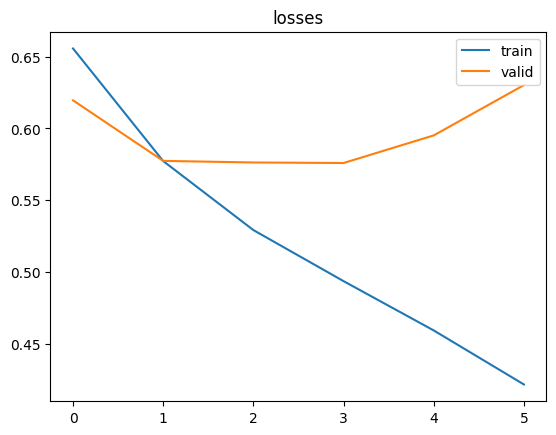

In [114]:
plt.title("losses")
plt.plot(losses["train_losses"], label="train")
plt.plot(losses["valid_losses"], label="valid")
plt.legend()
plt.show()

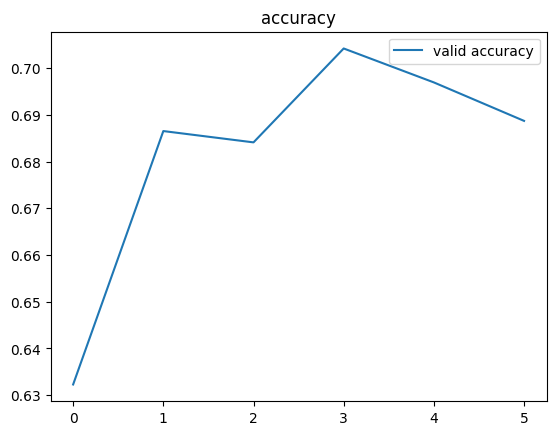

In [115]:
plt.title("accuracy")
plt.plot(losses["valid_acc"], label="valid accuracy")
plt.legend()
plt.show()

In [116]:
test_news_loss, test_news_acc = trainer.evaluate(test_news_dataloader)

In [117]:
print(f"Test loss {test_news_loss}, Test accuracy: {test_news_acc}")

Test loss 0.7072734031826258, Test accuracy: 0.664453125


In [118]:
test_tweets_loss, test_tweets_acc = trainer.evaluate(test_tweets_dataloader)

In [119]:
print(f"Test loss {test_tweets_loss}, Test accuracy: {test_tweets_acc}")

Test loss 0.7834143061190844, Test accuracy: 0.60625
